# Séance 2 - Réseau convolutionnel : Proposition de correction

Ce notebook est une proposition de correction pour le TP de la séance 2. Un travail différent peut être correct sans pour autant être identique à celui-là.

Commençons par importer l'ensemble des éléments dont nous aurons besoin.

In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = (fashion_mnist.load_data())
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.8)



from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28, 1)
X_valid = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28, 1)
X_test = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28, 1)

label_map = {0: "t-shirt/top", 1: "trouser", 2: "pullover",
             3: "dress", 4: "coat", 5: "sandal",
             6: "shirt", 7: "sneaker", 8: "bag", 9: "ankle boot"}

## Sujet C - ResNet à la main

Dans ce sujet, on souhaite écrire notre propre ResNet pour apprendre à classifier les classes du dataset FashionMNIST.

Pour aller plus loin que le sujet, on se propose de mesurer l'intérêt de définir un réseau résiduel par rapport à un réseau de neurones convolutionnel classique.
Nous allons donc définir un réseau résiduel et un réseau convolutionnel puis comparer les performances d'apprentissages. Pour lisser l'aléatoire présent dans l'initialisation, nous en lancerons plusieurs.

## Utilisation fonctionnelle de Keras

La librairie Keras permet de largement simplifier la définition d'un réseau de neurone. Nous avons déjà vu que l'on peut le définir comme une liste, mais nous pouvons également le faire comme une *fonction* : chaque élément du réseau de neurone sera un objet que l'on passera comme argument à l'objet suivant.

Commençons par définir un block des ResNet selon la recette initiale:
* Une couche de convolution avec padding pour conserver la taille de l'image
* Une couche de BatchNormalization, que l'on explicitera en cours à la séance prochaine
* L'activation ReLU, qui ne doit donc pas être présente dans la couche de convolution
* Une couche de convolution avec padding pour conserver la taille de l'image
* Une couche de BatchNormalization
* Un ajout de l'input et du résultat de la dernière couche de BatchNormalization
* L'activation ReLU sur l'ajout

Pour s'assurer un maximum de lisibilité, nous allons définir une fonction qui renverras la construction d'un ResBlock. Pour s'assurer une certaine flexibilité, nous exploiterons les *kwargs* dans la définition de la fonction. Cela nous permettra de modifier à volonter le design de la couche de convolution, sans avoir à modifier la fonction.

In [ ]:
def ResidualBlock(input, **kwargs):
  convolution = keras.layers.Conv2D(**kwargs)(input)
  normalization = keras.layers.BatchNormalization()(convolution)
  activation = keras.layers.ReLU()(normalization)

  convolution = keras.layers.Conv2D(**kwargs)(activation)
  normalization = keras.layers.BatchNormalization()(convolution)

  addition = keras.layers.Add()([input, normalization])
  output = keras.layers.ReLU()(addition)
  return output

Maintenant que c'est réalisé, nous pouvons définir notre modèle résiduel !

In [ ]:
def generate_resnet_model():
  input = keras.layers.Input(shape=X_train.shape[1:])
  hidden = keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same", kernel_initializer="he_normal")(input)
  starter_output = keras.layers.MaxPooling2D(pool_size=2)(hidden)

  block = ResidualBlock(input=starter_output, filters=64, kernel_size=3, padding="same", kernel_initializer="he_normal")
  block = ResidualBlock(input=block, filters=64, kernel_size=3, padding="same", kernel_initializer="he_normal")

  pooling = keras.layers.MaxPooling2D(pool_size=2)(block)
  flatten = keras.layers.Flatten()(pooling)
  hidden = keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal")(flatten)
  output = keras.layers.Dense(10, activation="softmax", kernel_initializer="he_normal")(hidden)

  model = keras.models.Model(inputs=[input], outputs=[output])
  return model

Vérifions que cette définition génère bien le réseau que l'on souhaite :

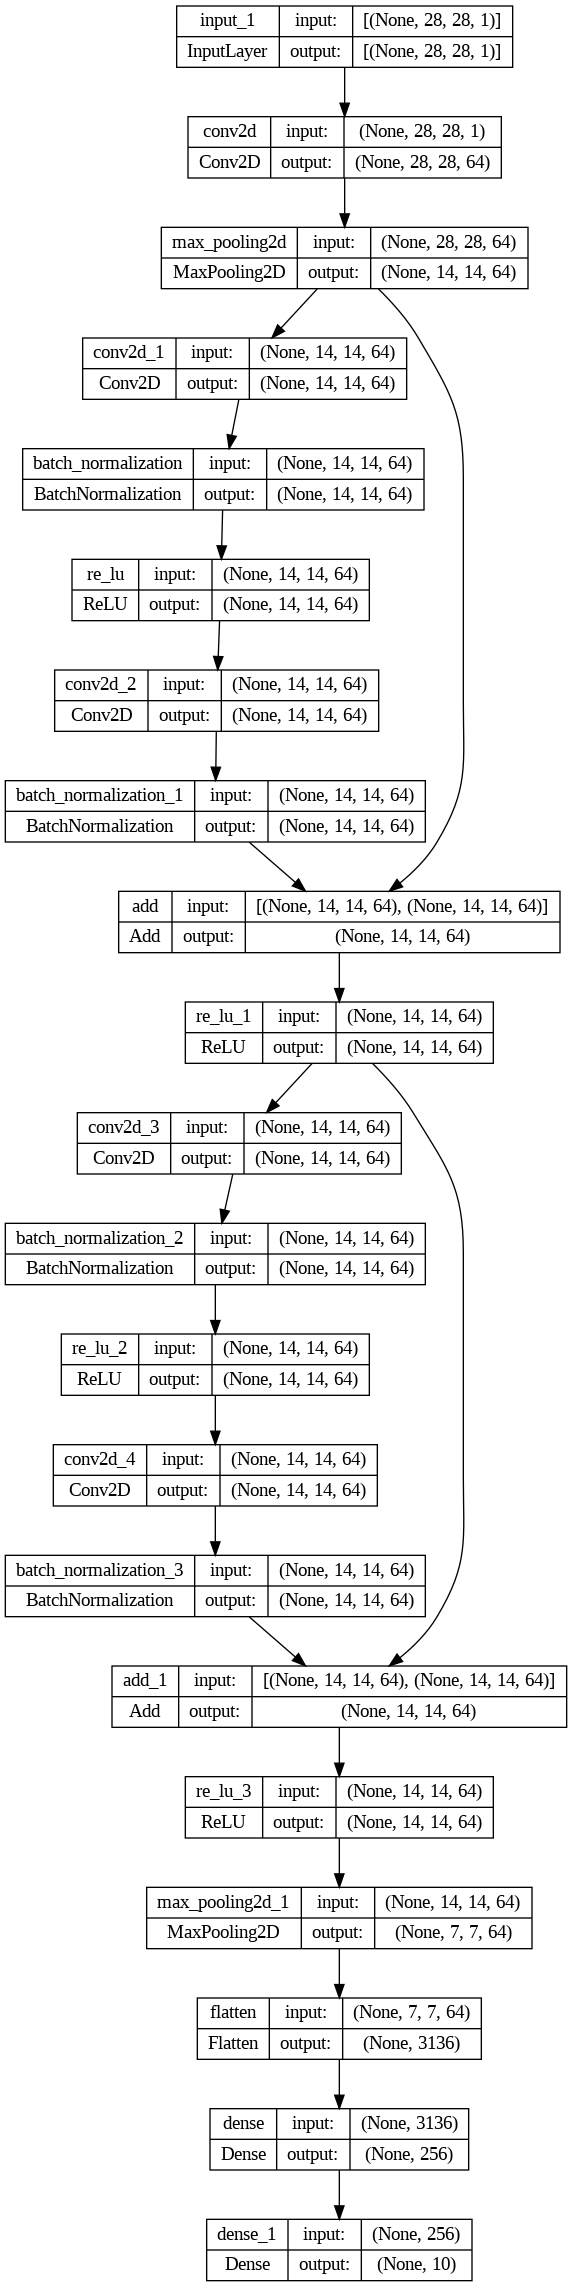

In [ ]:
model_resnet = generate_resnet_model()
keras.utils.plot_model(model_resnet, show_shapes=True)

C'est exactement ce que nous souhaitions ! Combien y a-t-il de paramètres au total ?

In [ ]:
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 64)           640       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 64)           36928     ['max_pooling2d[0][0]']   

Presque un million de paramètres ! Notons au passage que la couche de BatchNormalization contient des paramètres appris...

Passons à un modèle identique, mais sans les connexions résiduelles.

In [ ]:
def generate_cnn_model():
  model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal", input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),

    keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),

    keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),

    keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),

    keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),

    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(10, activation="softmax", kernel_initializer="he_normal")
  ])
  return model

Vérifions que le nombre de paramètres est identique.

In [ ]:
model_cnn = generate_cnn_model()
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 batch_normalization_4 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 re_lu_4 (ReLU)              (None, 14, 14, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        3

C'est identique ! Nous avons donc exactement le même réseau avec et sans les connexion résiduelles. Notons que nous avons fait attention à séparer l'activation de la couche de convolution pour s'assurer que les différences que nous observerons seront uniquement lié à ces connexions résiduelles.

Nous pouvons à présent lancer les calculs pour comparer les modèles !


## Entraînement

Nous allons entrainer trois fois les deux types d'architecture. Elles sont de taille relativement importante et profonde, donc nous choisirons un learning rate plus faible que d'habitude, mais nous l'entraînerons aussi un peu plus longtemps.

In [ ]:
def train_model(model, learning_rate=1e-3, epochs=10, verbose=0):
  model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=learning_rate), metrics=["accuracy"])
  history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), verbose=verbose)
  return pd.DataFrame(history.history)

n_epochs = 75
learning_rate = 1e-4
comparisons_number = 3
results = []

for index in range(comparisons_number):
  print("Comparison %d :" % (index+1), end=" ")
  for generate_function, network_type in zip([generate_resnet_model, generate_cnn_model], ["ResNet", "CNN"]):
    print("%s..." % network_type, end= " ")
    model = generate_function()
    history = train_model(model, learning_rate=learning_rate, epochs=n_epochs)
    result = {"type": network_type, "history": history}
    results.append(result)
  print()

Comparison 1 : ResNet... CNN... 
Comparison 2 : ResNet... CNN... 
Comparison 3 : ResNet... CNN... 


Nous souhaitons être capable de visualiser les courbes d'apprentissage des deux modèles. Pour cela, nous allons agréger les performances, pour chaque type, des trois modèles entraînés.
Nous conserverons les performances sur le *train* et la *validation* pour la valeur de la fonction de perte et l'accuracy.

Cette étape peut être reprise dans la suite de nos expérimentations avec les réseaux de neurones, nous definissons donc une fonction pour la réutiliser plus tard.

In [ ]:
def agregate_result(network_type, metric_name):
  training = np.zeros((comparisons_number, n_epochs))
  validation = np.zeros((comparisons_number, n_epochs))
  index = 0
  for result in results:
    if result["type"] == network_type:
      historic = result["history"]
      training[index] = historic[metric_name]
      validation[index] = historic["val_%s" % metric_name]
      index += 1
  return training, validation

Nous pouvons à présent afficher les deux courbes d'apprentissages. Une courbe d'apprentissage correspondra à la moyenne des performances pour chaque époque, et on trace également un intervalle de confiance à 95% autour de cette moyenne.

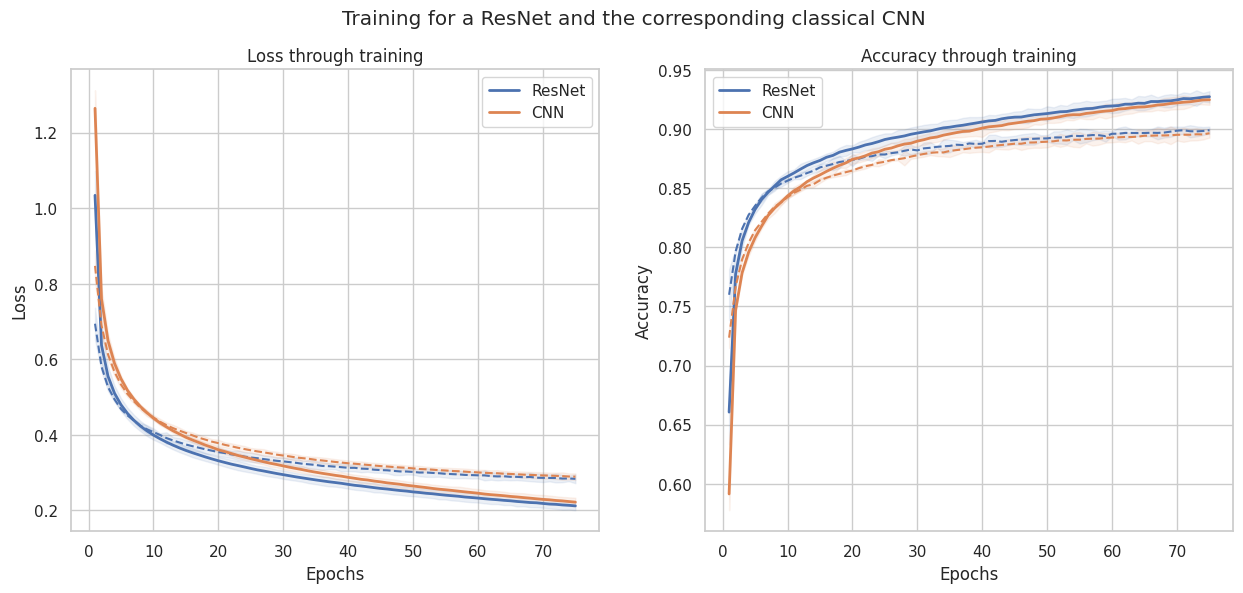

In [ ]:
epochs = range(1, n_epochs+1)

figure, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(15, 6))

for metric_name, axis in zip(["loss", "accuracy"], [axis_1, axis_2]):

  for index, network_type in enumerate(["ResNet", "CNN"]):
    color = sns.color_palette()[index]
    training, validation = agregate_result(network_type, metric_name)
    axis.plot(epochs, training.mean(axis=0), lw=2, label=network_type, color=color)
    axis.fill_between(epochs, training.mean(axis=0)-3*training.std(axis=0), training.mean(axis=0)+3*training.std(axis=0), color=color, alpha=0.1)
    axis.plot(epochs, validation.mean(axis=0), ls="--", color=color)
    axis.fill_between(epochs, validation.mean(axis=0)-3*validation.std(axis=0), validation.mean(axis=0)+3*validation.std(axis=0), color=color, alpha=0.1)

  #axis.set_ylim(0, 1)
  axis.set_ylabel(metric_name.capitalize())
  axis.set_xlabel("Epochs")
  axis.set_title("%s through training" % metric_name.capitalize())
  axis.legend()


plt.suptitle("Training for a ResNet and the corresponding classical CNN")
plt.show()

Les performances sont similaires, mais le ResNet *apprend* plus vite ! Avec un meilleur choix de learning rate, on pourrait obtenir de meilleurs résultatsplus rapidement avec un ResNet pour lequel on arrêterai l'entraînement plus tôt. Par exemple, la performance du ResNet à l'époque 40 est obtenu pour le réseau convolutionnel classique 10 époques plus tard.

Cette conclusion est valable uniquement pour cette architecture et ces paramètres d'entraînements spécifique. On peut cependant garder en tête que la performance peut être *améliorée* en ajoutant des connexions *résiduels*.